## Importar la base de datos, transformada en excel

Primero, eliminamos varias columnas que no son de interes, como valor neto chunk y otras más que solo tienen entradas de 0. Para esto vamos a volver la base de datos a formato csv y la vamos a guardar en la nube.

In [1]:
import pandas as pd

#David M Path:  r"C:\Users\David\Universidad de los andes\David Stiven Romero Grajales - Trabajo de Grado\Trabajo de Grado 1\Base de datos y descripción\Entrenamiento_cronicas_N.pkl"
df_health = pd.read_csv(r'C:\Users\David\Universidad de los andes\David Stiven Romero Grajales - Trabajo de Grado\Trabajo de Grado 1\Base de datos y descripción\Entrenamiento_cronicas_N.csv')


Limpiemos nuestra base, y convirtamos todas las columnas a su respectiva categoria, pera entrenar nuestos modelos y algoritmos.

In [2]:

# 1. EPS - Categorical
df_health['EPS'] = df_health['EPS'].astype('category')

# 2. NUM_IDE - Identifier, string
df_health['NUM_IDE'] = df_health['NUM_IDE'].astype(str)

# 3. FECHA_NACI - Convert to datetime
df_health['FECHA_NACI'] = pd.to_datetime(df_health['FECHA_NACI'], errors='coerce')

# 4. SEXO - Categorical
df_health['SEXO'] = df_health['SEXO'].astype('category')

# 5. DPTO - Categorical
df_health['DPTO'] = df_health['DPTO'].astype('category')

# 6. MUNI - Categorical
df_health['MUNI'] = df_health['MUNI'].astype('category')

# 7. DIAS_COMP - Numeric
df_health['DIAS_COMP'] = pd.to_numeric(df_health['DIAS_COMP'], errors='coerce')

# 8. V8 - Categorical
df_health['V8'] = df_health['V8'].astype('category')

df_health['Valor_Neto'] = pd.to_numeric(df_health['Valor_Neto'], errors='coerce')

# 11. DIAS_ESTAN_Neto_Chunk and DIAS_ESTAN_Neto - Numeric
df_health['DIAS_ESTAN_Neto'] = pd.to_numeric(df_health['DIAS_ESTAN_Neto'], errors='coerce')

# 12. Edad - Numeric
df_health['Edad'] = pd.to_numeric(df_health['Edad'], errors='coerce')

# 13. Illness Columns - Numeric (binary)
illness_columns = [
    'SIDA_VIH', 'TUBERCULOSIS', 'CANCER_OTROSCANCER', 'CANCER_ORGANOSDIGESTIVOS', 
    'CANCER_ORGANOSRESPIRATORIOS', 'CANCER_MELANOMAYDELAPIEL', 'CANCER_MAMA', 
    'CANCER_OTROSGENITALESFEMENINOS', 'CANCER_CERVIXINVASIVO', 'CANCER_GENITALESMASCULINOS', 
    'CANCER_TEJIDOLINFATICOYAFINES', 'CANCER_CERVIXINSITU', 'AUTOINMUNE', 'DIABETES', 
    'SINDROMESCONVULSIVOS(EPILEPSIA)', 'ENFERMEDADCARDIOVASCULAR_OTRA', 
    'ENFERMEDADCARDIOVASCULAR_HIPERTENSION', 'ENFERMEDADPULMONARDELARGADURACION', 
    'ASMA', 'ARTRITISPIOGENASYREACTIVAS', 'ARTRITIS', 'ARTROSIS', 'RENAL_OTRA', 
    'RENAL_RENALDELARGADURACION', 'TRANSPLANTE', 'RENAL_INSUFICIENCIARENALOTRA', 
    'RENAL_INSUFICIENCIARENALCRONICA', 'ANOMALIASGENETICASYCONGENITAS', 
    'CANCER_TERAPIACANCER'
]

df_health[illness_columns] = df_health[illness_columns].apply(pd.to_numeric, errors='coerce')

# 14. Grupo_Edad - Categorical
df_health['Grupo_Edad'] = df_health['Grupo_Edad'].astype('category')

# 15. Zona - Categorical
df_health['Zona'] = df_health['Zona'].astype('category')
print(df_health.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996234 entries, 0 to 996233
Data columns (total 42 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   EPS                                    996234 non-null  category      
 1   NUM_IDE                                996234 non-null  object        
 2   FECHA_NACI                             996234 non-null  datetime64[ns]
 3   SEXO                                   996234 non-null  category      
 4   DPTO                                   996234 non-null  category      
 5   MUNI                                   996234 non-null  category      
 6   DIAS_COMP                              996234 non-null  int64         
 7   V8                                     996234 non-null  category      
 8   Valor_Neto                             996234 non-null  int64         
 9   DIAS_ESTAN_Neto                        996234 no

Ahora, buscamos ver la cantidad de valores nulos en nuestros datos, y en las variables de one-hot encoding, ver la cantidad de 0 y 1 para ver la distribución de los datos

In [3]:
# Count the number of NaNs, zeros, and ones for each column
nan_counts = df_health.isna().sum()
zero_counts = (df_health == 0).sum()
one_counts = (df_health == 1).sum()

# Calculate the percentage of zeros and ones for each column
zero_percentage = (zero_counts / len(df_health)) * 100
one_percentage = (one_counts / len(df_health)) * 100

# Create a dataframe to display the counts of NaNs, zeros, ones, and percentages
cleaning_summary = pd.DataFrame({
    'NaN_Count': nan_counts,
    'Zero_Count': zero_counts,
    'Zero_Percentage': zero_percentage,
    'One_Count': one_counts,
    'One_Percentage': one_percentage
})

# Display the result
print(cleaning_summary)


                                       NaN_Count  Zero_Count  Zero_Percentage  \
EPS                                            0           0         0.000000   
NUM_IDE                                        0           0         0.000000   
FECHA_NACI                                     0           0         0.000000   
SEXO                                           0           0         0.000000   
DPTO                                           0           0         0.000000   
MUNI                                           0           0         0.000000   
DIAS_COMP                                      0           0         0.000000   
V8                                             0           0         0.000000   
Valor_Neto                                     0      357718        35.907026   
DIAS_ESTAN_Neto                                0      524287        52.626893   
Edad                                           0       11023         1.106467   
SIDA_VIH                    

# 1. Target Encoding (Mean Encoding)

In Target Encoding, categorical variables are replaced with the mean of the target variable (e.g., for classification, the probability of the target class given the category). This helps avoid the increase in dimensionality but may lead to overfitting if not done properly.

In [35]:
from sklearn.model_selection import KFold

def target_encode(train_series, target_series, n_folds=5):
    mean_encoded_series = pd.Series(index=train_series.index)
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    for train_idx, test_idx in kf.split(train_series):
        X_train, X_test = train_series.iloc[train_idx], train_series.iloc[test_idx]
        y_train = target_series.iloc[train_idx]
        
        # Calculate mean for the training fold
        means = y_train.groupby(X_train).mean()
        
        # Apply means to the test fold
        mean_encoded_series.iloc[test_idx] = X_test.map(means)
    
    return mean_encoded_series

# Target encoding with K-Fold Cross-Validation
df_health['SEXO_Target_Encoded'] = target_encode(df_health['SEXO'], df_health['Valor_Neto'])
df_health['DPTO_Target_Encoded'] = target_encode(df_health['DPTO'], df_health['Valor_Neto'])
df_health['MUNI_Target_Encoded'] = target_encode(df_health['MUNI'], df_health['Valor_Neto'])




C:\Users\David\AppData\Local\Temp\ipykernel_18880\2459162362.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = y_train.groupby(X_train).mean()


AssertionError: Something has gone wrong, please report a bug at https://github.com/pandas-dev/pandas/issues

Ahora queremos ver un análisis de correlación de los datos, qué variables no tienen ninguna información relevante para nuestro módelo? Miremos entonces la matriz de correlación para las variables númericas.

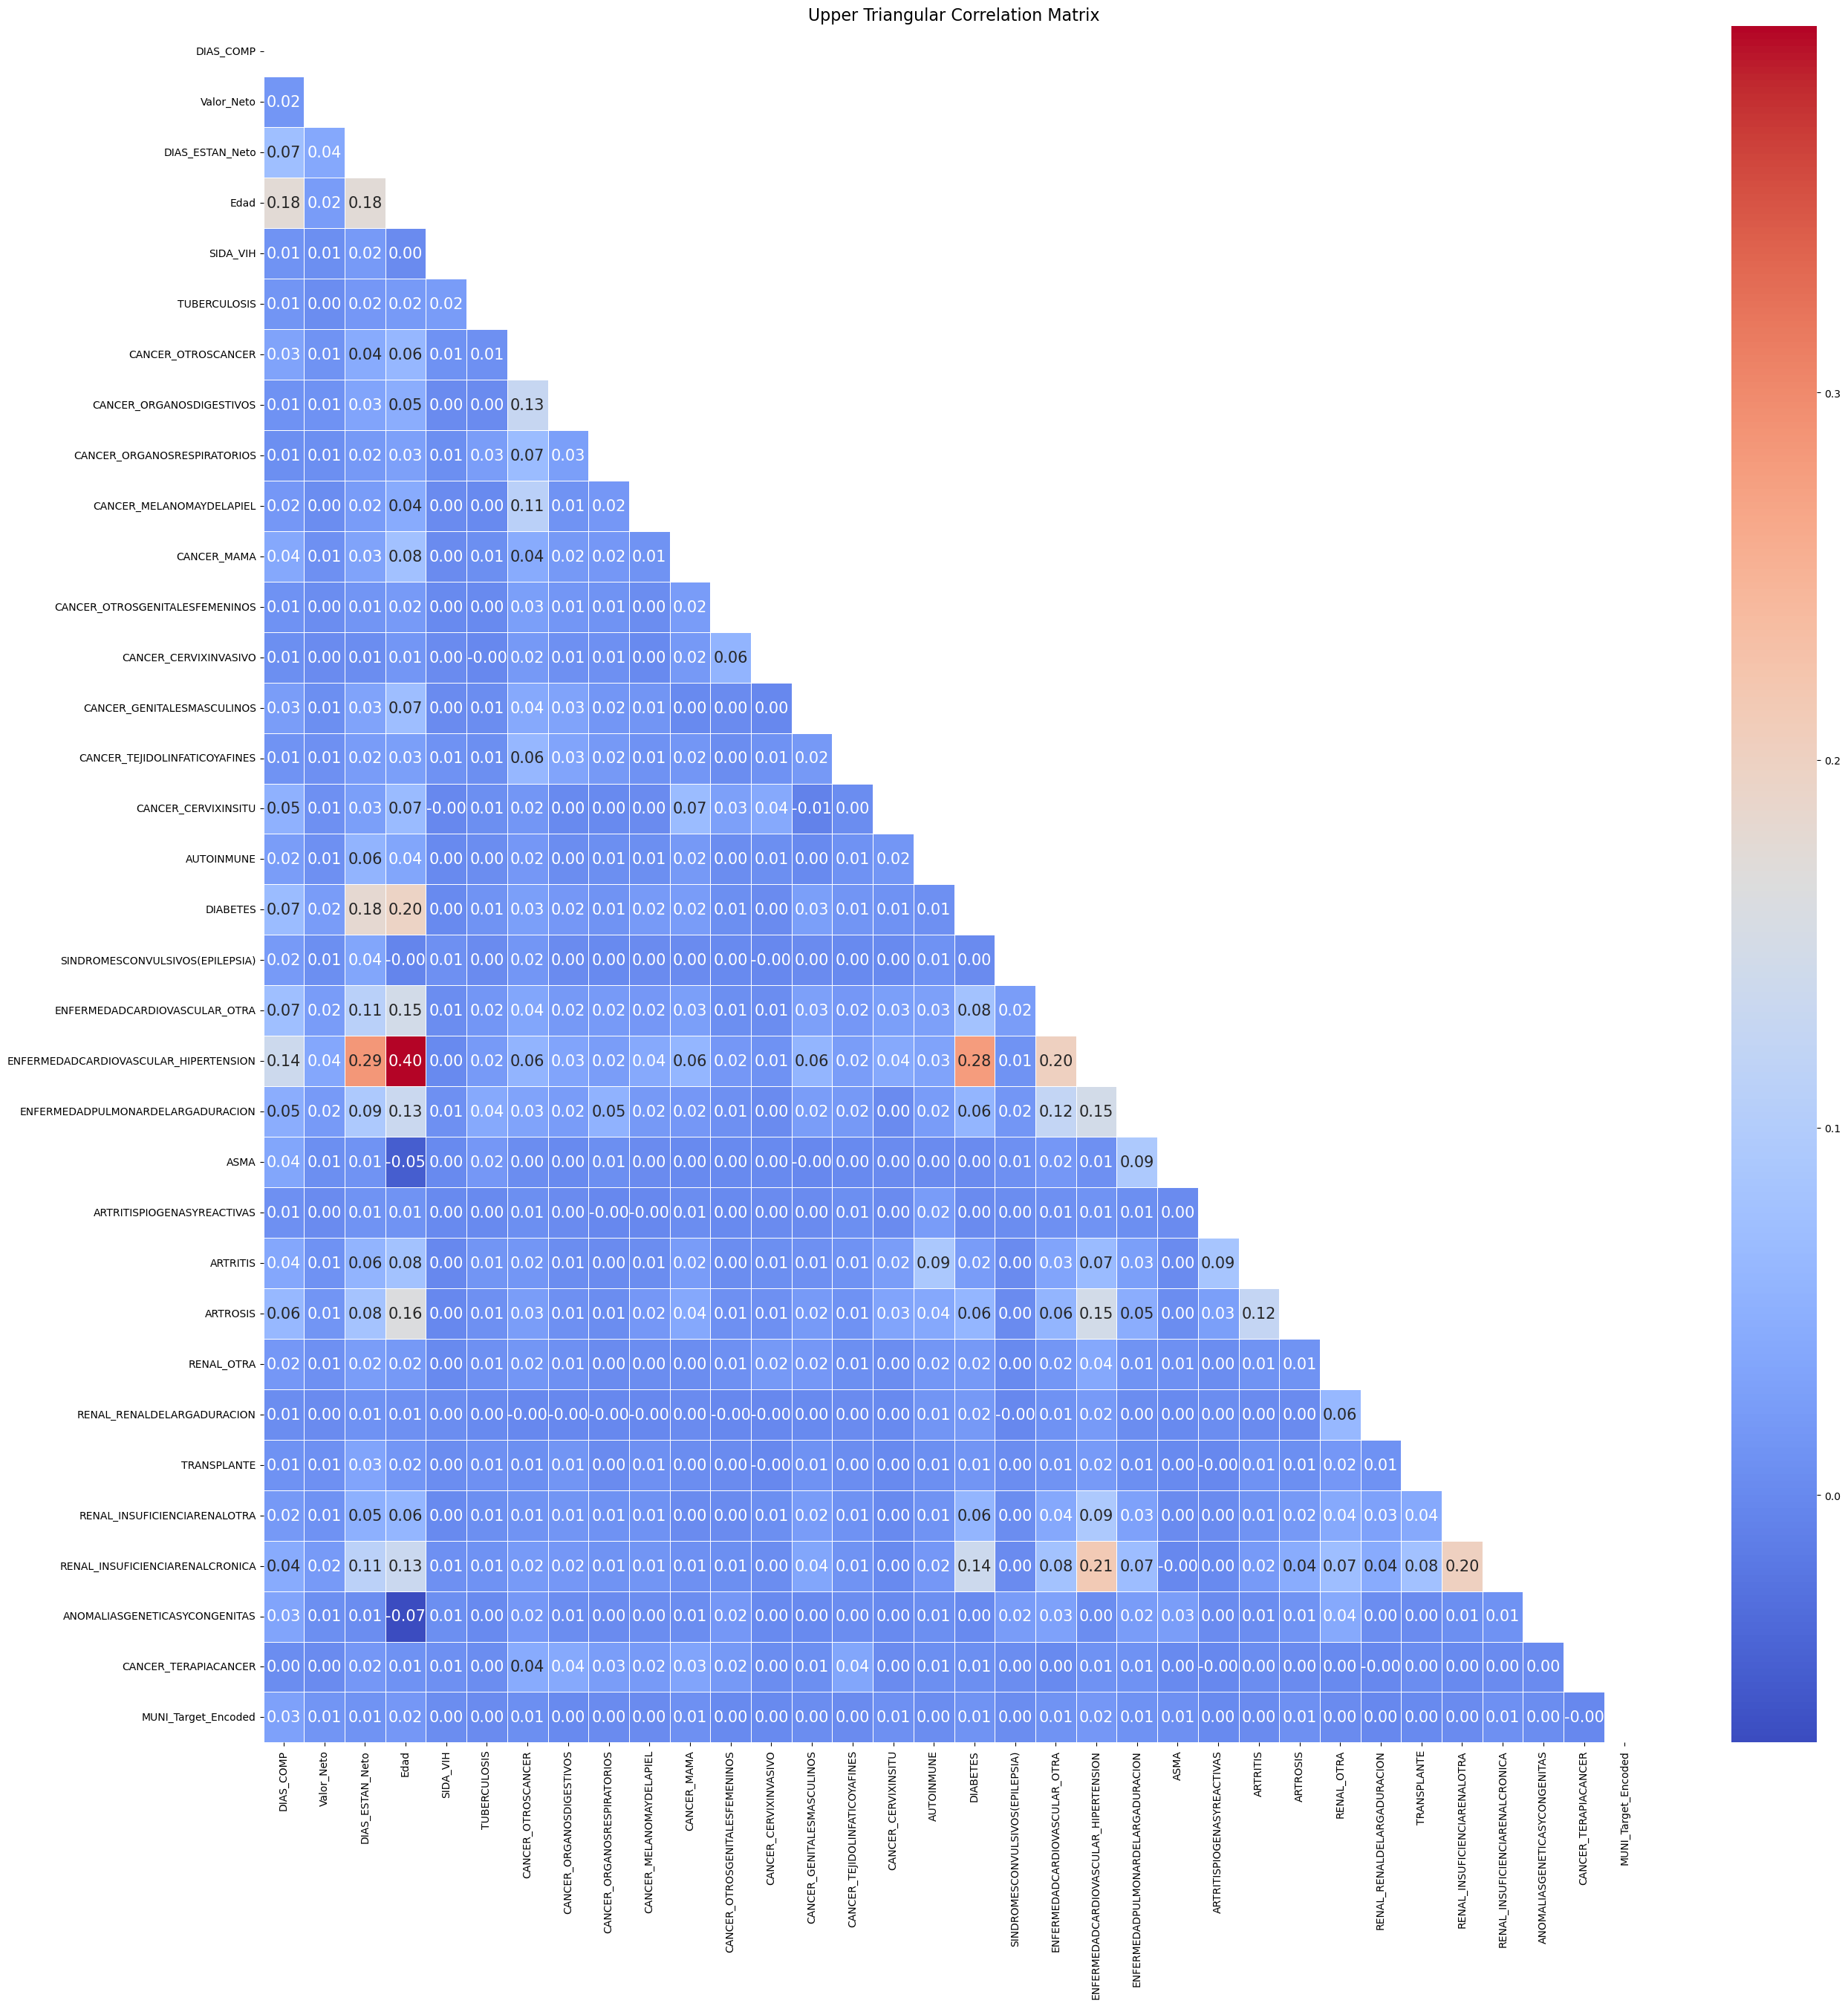

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Select only numeric columns from the dataframe
numeric_df = df_health.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix for numeric columns
corr_matrix = numeric_df.corr()

# Create a mask for the upper triangle (upper diagonal)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure with larger size
plt.figure(figsize=(30, 30))  # Increase figure size to make boxes bigger

# Draw the heatmap with the mask, hiding the lower triangle
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 15})

# Add title
plt.title('Upper Triangular Correlation Matrix', fontsize=16)

# Display the plot
plt.show()



In this graph, we observe some notable insights, while others are less significant. Our goal is to predict "Valor Neto," but the relationship with this variable does not appear to be linear, and there is minimal correlation with the other variables. This poses a challenge for inference, as it suggests that a linear model may not provide much explanatory power.

However, in the case of variables like "Edad," we do see correlations, particularly with "Hipertensión," which shows the highest value (in red). There are also notable correlations with other conditions like "Insuficiencia Renal" and "Artrosis." Additionally, the variable "días estas" shows correlations with certain diseases. On the positive side, most of the variables do not suffer from multicollinearity, which is good news for further analysis.

Valor_Neto                               1.000000
DIAS_ESTAN_Neto                          0.039998
ENFERMEDADCARDIOVASCULAR_HIPERTENSION    0.036712
ENFERMEDADCARDIOVASCULAR_OTRA            0.023683
DIABETES                                 0.023571
Edad                                     0.023390
ENFERMEDADPULMONARDELARGADURACION        0.021528
RENAL_INSUFICIENCIARENALCRONICA          0.020943
DIAS_COMP                                0.016189
ARTROSIS                                 0.013344
CANCER_OTROSCANCER                       0.011607
CANCER_ORGANOSDIGESTIVOS                 0.010927
RENAL_INSUFICIENCIARENALOTRA             0.010510
ARTRITIS                                 0.010473
CANCER_TEJIDOLINFATICOYAFINES            0.009233
CANCER_CERVIXINSITU                      0.008481
TRANSPLANTE                              0.008108
CANCER_MAMA                              0.007828
AUTOINMUNE                               0.007736
RENAL_OTRA                               0.007514


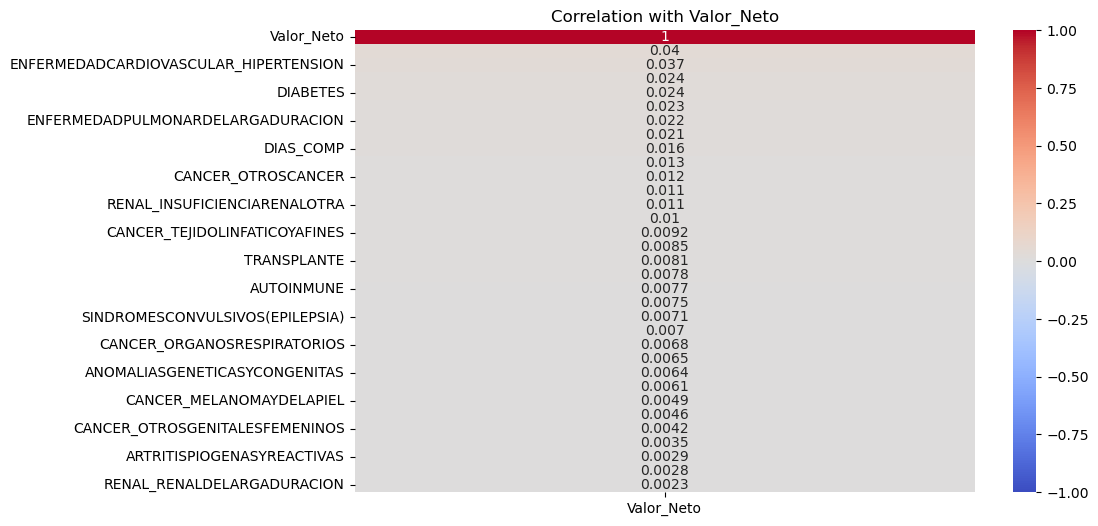

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting all numeric columns, including binary illness columns
illness_columns = [
    'SIDA_VIH', 'TUBERCULOSIS', 'CANCER_OTROSCANCER', 'CANCER_ORGANOSDIGESTIVOS', 
    'CANCER_ORGANOSRESPIRATORIOS', 'CANCER_MELANOMAYDELAPIEL', 'CANCER_MAMA', 
    'CANCER_OTROSGENITALESFEMENINOS', 'CANCER_CERVIXINVASIVO', 'CANCER_GENITALESMASCULINOS', 
    'CANCER_TEJIDOLINFATICOYAFINES', 'CANCER_CERVIXINSITU', 'AUTOINMUNE', 'DIABETES', 
    'SINDROMESCONVULSIVOS(EPILEPSIA)', 'ENFERMEDADCARDIOVASCULAR_OTRA', 
    'ENFERMEDADCARDIOVASCULAR_HIPERTENSION', 'ENFERMEDADPULMONARDELARGADURACION', 
    'ASMA', 'ARTRITISPIOGENASYREACTIVAS', 'ARTRITIS', 'ARTROSIS', 'RENAL_OTRA', 
    'RENAL_RENALDELARGADURACION', 'TRANSPLANTE', 'RENAL_INSUFICIENCIARENALOTRA', 
    'RENAL_INSUFICIENCIARENALCRONICA', 'ANOMALIASGENETICASYCONGENITAS', 
    'CANCER_TERAPIACANCER'
]

# Add other numeric variables of interest like 'Edad', 'DIAS_COMP', etc.
numeric_columns = ['Valor_Neto', 'Edad', 'DIAS_COMP', 'DIAS_ESTAN_Neto'] + illness_columns

# Filter only relevant numeric columns for analysis
df_numeric = df_health[numeric_columns]

# Calculate correlation only with 'Valor_Neto'
correlation_with_valor_neto = df_numeric.corr()['Valor_Neto'].sort_values(ascending=False)

# Display the correlations
print(correlation_with_valor_neto)

# Optionally, visualize the correlation with a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_with_valor_neto.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
plt.title('Correlation with Valor_Neto')
plt.show()


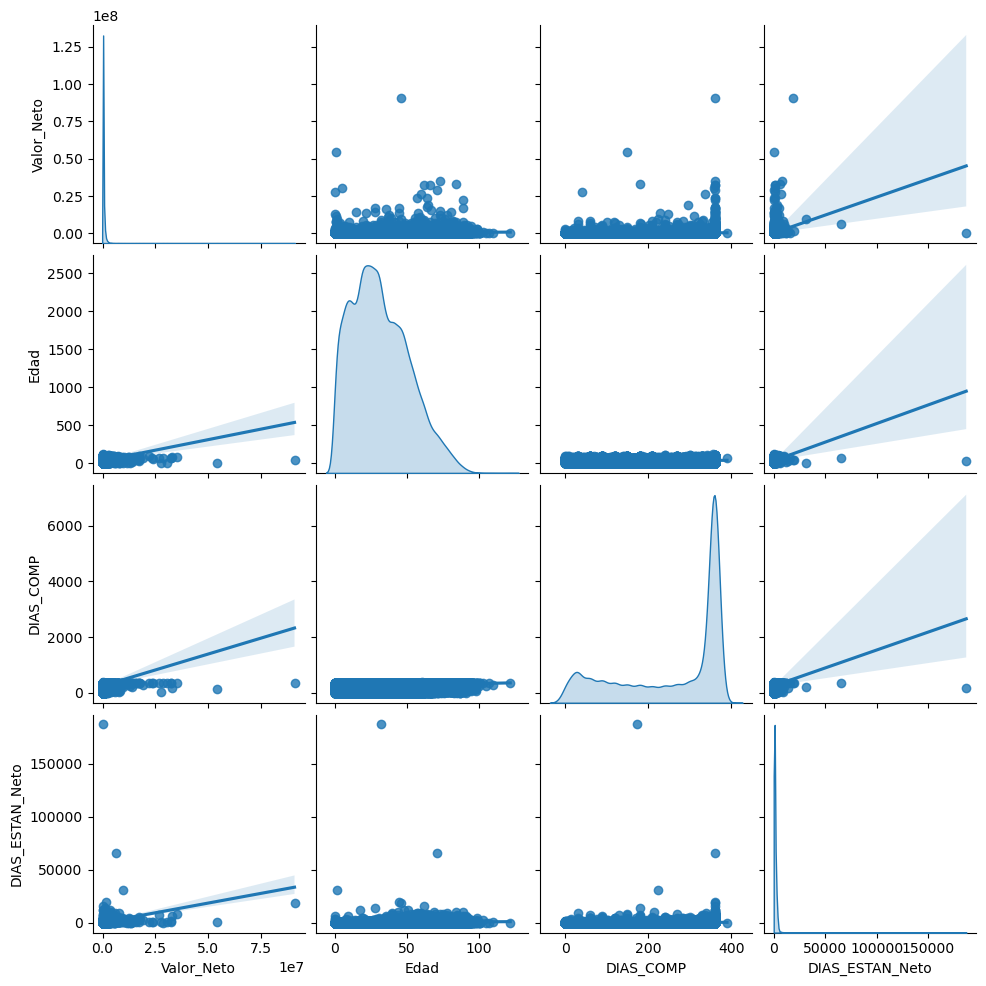

In [7]:
# Randomly sample 100,000 rows
numeric_columns = ['Valor_Neto', 'Edad', 'DIAS_COMP', 'DIAS_ESTAN_Neto']
df_sample = df_health[numeric_columns].sample(n=100000, random_state=42)

# Create the pairplot on the sampled data 
sns.pairplot(df_sample, kind="reg", diag_kind="kde")
plt.show()


# 3. Vamos a limpiar los datos

In [10]:
import pandas as pd

# List of binary illness columns
illness_columns = [
    'SIDA_VIH', 'TUBERCULOSIS', 'CANCER_OTROSCANCER', 'CANCER_ORGANOSDIGESTIVOS', 
    'CANCER_ORGANOSRESPIRATORIOS', 'CANCER_MELANOMAYDELAPIEL', 'CANCER_MAMA', 
    'CANCER_OTROSGENITALESFEMENINOS', 'CANCER_CERVIXINVASIVO', 'CANCER_GENITALESMASCULINOS', 
    'CANCER_TEJIDOLINFATICOYAFINES', 'CANCER_CERVIXINSITU', 'AUTOINMUNE', 'DIABETES', 
    'SINDROMESCONVULSIVOS(EPILEPSIA)', 'ENFERMEDADCARDIOVASCULAR_OTRA', 
    'ENFERMEDADCARDIOVASCULAR_HIPERTENSION', 'ENFERMEDADPULMONARDELARGADURACION', 
    'ASMA', 'ARTRITISPIOGENASYREACTIVAS', 'ARTRITIS', 'ARTROSIS', 'RENAL_OTRA', 
    'RENAL_RENALDELARGADURACION', 'TRANSPLANTE', 'RENAL_INSUFICIENCIARENALOTRA', 
    'RENAL_INSUFICIENCIARENALCRONICA', 'ANOMALIASGENETICASYCONGENITAS', 
    'CANCER_TERAPIACANCER'
]

# Add other numeric variables of interest like 'Edad', 'DIAS_COMP', etc.
numeric_columns = ['Valor_Neto', 'Edad', 'DIAS_COMP', 'DIAS_ESTAN_Neto'] + illness_columns

# Filter the dataframe to select only the specified columns
df_clean = df_health[numeric_columns]


,Valor_Neto,Edad,DIAS_COMP,DIAS_ESTAN_Neto,SIDA_VIH,TUBERCULOSIS,CANCER_OTROSCANCER,CANCER_ORGANOSDIGESTIVOS,CANCER_ORGANOSRESPIRATORIOS,CANCER_MELANOMAYDELAPIEL,...,ARTRITISPIOGENASYREACTIVAS,ARTRITIS,ARTROSIS,RENAL_OTRA,RENAL_RENALDELARGADURACION,TRANSPLANTE,RENAL_INSUFICIENCIARENALOTRA,RENAL_INSUFICIENCIARENALCRONICA,ANOMALIASGENETICASYCONGENITAS,CANCER_TERAPIACANCER
0,39054,12,360,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,312012,23,336,277,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14313,15,333,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,13,84,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,21,180,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996229,96085,31,360,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996230,0,47,215,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996231,0,30,30,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996232,70114,32,360,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
import pandas as pd
from sklearn.ensemble import IsolationForest

# Lista de columnas numéricas para la limpieza de outliers
numeric_columns = ['Valor_Neto', 'Edad', 'DIAS_COMP', 'DIAS_ESTAN_Neto']

# Filtrar el dataframe para seleccionar solo las columnas que queremos limpiar
df_cleaned_outliers = df_health[numeric_columns].copy()

# Aplicar Isolation Forest para detectar outliers
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(df_cleaned_outliers)

# Filtrar el dataframe y quedarnos solo con los puntos que no son outliers (outliers == 1)
df_cleaned_outliers = df_cleaned_outliers[outliers == 1]

# Mostrar las primeras filas del dataframe limpio de outliers
print(df_cleaned_outliers)




    Valor_Neto  Edad  DIAS_COMP  DIAS_ESTAN_Neto
3            0    13         84                0
4            0    21        180                0
6            0    32        360                0
9            0    30        282                0
21           0    21        240                0


In [23]:
df_cleaned_outliers

,Valor_Neto,Edad,DIAS_COMP,DIAS_ESTAN_Neto
3,0,13,84,0
4,0,21,180,0
6,0,32,360,0
9,0,30,282,0
21,0,21,240,0
...,...,...,...,...
996225,0,12,270,0
996228,0,0,50,0
996230,0,47,215,0
996231,0,30,30,0


Pipeline de limpieza

In [8]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

numeric_columns = ['DIAS_COMP', 'DIAS_ESTAN_Neto', 'Edad']

model = LinearRegression()

for col in numeric_columns:
    X = df_health[[col]]  
    y = df_health['Valor_Neto']  
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    print(f'R² for {col}: {r2}')


R² for DIAS_COMP: 0.00026207309567338744
R² for DIAS_ESTAN_Neto: 0.001599841547789027
R² for Edad: 0.0005470810611043486


In [19]:
df_health_clean = df_health.dropna(subset=['SEXO', 'DPTO', 'Zona', 'Grupo_Edad'])


In [55]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd

# List of categorical, illness, and numeric columns
categorical_columns = ['SEXO', 'DPTO', 'Zona', 'Grupo_Edad']
illness_columns = ['SIDA_VIH', 'TUBERCULOSIS', 'CANCER_OTROSCANCER', 'CANCER_ORGANOSDIGESTIVOS', 
                   'CANCER_ORGANOSRESPIRATORIOS', 'CANCER_MELANOMAYDELAPIEL', 'CANCER_MAMA', 
                   'CANCER_OTROSGENITALESFEMENINOS', 'CANCER_CERVIXINVASIVO', 'CANCER_GENITALESMASCULINOS', 
                   'CANCER_TEJIDOLINFATICOYAFINES', 'CANCER_CERVIXINSITU', 'AUTOINMUNE', 'DIABETES', 
                   'SINDROMESCONVULSIVOS(EPILEPSIA)', 'ENFERMEDADCARDIOVASCULAR_OTRA', 
                   'ENFERMEDADCARDIOVASCULAR_HIPERTENSION', 'ENFERMEDADPULMONARDELARGADURACION', 
                   'ASMA', 'ARTRITISPIOGENASYREACTIVAS', 'ARTRITIS', 'ARTROSIS', 'RENAL_OTRA', 
                   'RENAL_RENALDELARGADURACION', 'TRANSPLANTE', 'RENAL_INSUFICIENCIARENALOTRA', 
                   'RENAL_INSUFICIENCIARENALCRONICA', 'ANOMALIASGENETICASYCONGENITAS', 
                   'CANCER_TERAPIACANCER']

numeric_columns = ['DIAS_COMP', 'DIAS_ESTAN_Neto', 'Edad']

# Combine all columns you need
all_columns = categorical_columns + illness_columns + numeric_columns + ['Valor_Neto']

# Select the relevant columns from your DataFrame
df_health_selected = df_health[all_columns]

df_health_selected[categorical_columns] = df_health_selected[categorical_columns].astype(str)

# Prepare the data for CatBoost
X = df_health_selected.drop(columns=['Valor_Neto'])  # Features
y = df_health_selected['Valor_Neto']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the CatBoost Regressor
catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, cat_features=categorical_columns, verbose=100)

# Fit the model
catboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = catboost_model.predict(X_test)

# Evaluate the model performance
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'R^2 Score: {r2}')
print(f'Mean Absolute Error: {mae}')

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual Values')
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Valor_Neto')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.show()



C:\Users\David\AppData\Local\Temp\ipykernel_18880\1746701354.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_health_selected[categorical_columns] = df_health_selected[categorical_columns].astype(str)


CatBoostError: catboost/cuda/cuda_lib/cuda_base.h:281: CUDA error 35: CUDA driver version is insufficient for CUDA runtime version

c:\Users\David\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1972: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\Users\David\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1972: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\Users\David\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1972: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
c:\User

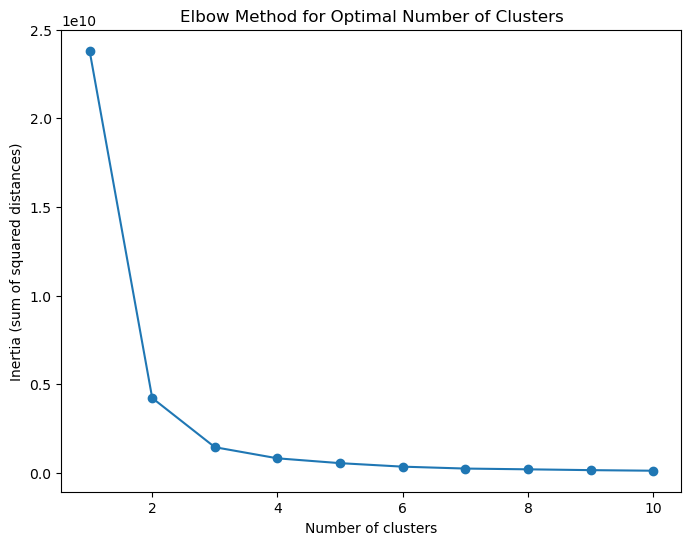

In [61]:
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

# Create an empty list to store the inertia for each number of clusters
inertia_values = []

# Range of clusters to try
cluster_range = range(1, 11)

# Loop over different numbers of clusters and calculate inertia (sum of squared distances)
for n_clusters in cluster_range:
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=1000, random_state=42)
    kmeans.fit(dpto_muni_features)
    inertia_values.append(kmeans.inertia_)

# Plot the inertia values for different numbers of clusters
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia_values, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (sum of squared distances)')
plt.show()



In [63]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Create an empty list to store the silhouette scores for each number of clusters
silhouette_scores = []

# Range of clusters to try (start from 2 to avoid the error)
cluster_range = range(2, 11)

# Loop over different numbers of clusters and calculate the silhouette score
for n_clusters in cluster_range:
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=1000, random_state=42)
    cluster_labels = kmeans.fit_predict(dpto_muni_features)
    
    # Calculate the silhouette score for the current number of clusters
    silhouette_avg = silhouette_score(dpto_muni_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores for different numbers of clusters
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()


c:\Users\David\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1972: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
